In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
llm = init_chat_model("google_genai:gemini-2.0-flash")


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

def calculator(state: State):
    last_msg = state["messages"][-1].content
    try:
        result = eval(last_msg, {"__builtins__": {}}, {})
        reply = {"role": "assistant", "content": str(result)}
    except Exception as e:
        reply = {"role": "assistant", "content": f"Error in calculation: {e}"}
    return {"messages": state["messages"] + [reply]}

def router(state: State):
    last_msg = state["messages"][-1].content 
    if any(op in last_msg for op in "+-*/()") and all(c.isdigit() or c.isspace() or c in "+-*/()." for c in last_msg):
        return {"next": "calculator"}
    return {"next": "chatbot"}

graph_builder.add_node("router", router)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("calculator", calculator)
graph_builder.add_edge(START, "router")
graph_builder.add_conditional_edges("router", 
    lambda state: state.get("next"),
    {
        "chatbot": "chatbot",
        "calculator": "calculator"
    }
)
graph_builder.add_edge("chatbot", END)
graph_builder.add_edge("calculator", END)


graph = graph_builder.compile()



In [4]:
def run_chatbot():
    state = {"messages": [], "message_type": None}

    while True:
        user_input = input("Message: ")
        if user_input == "exit":
            print("Bye")
            break

        state["messages"] = state.get("messages", []) + [
            {"role": "user", "content": user_input}
        ]

        state = graph.invoke(state)

        if state.get("messages") and len(state["messages"]) > 0:
            last_message = state["messages"][-1]
            print(f"Assistant: {last_message.content}")

In [5]:
run_chatbot()

Assistant: Hi there! How can I help you today?
Assistant: 3
Bye


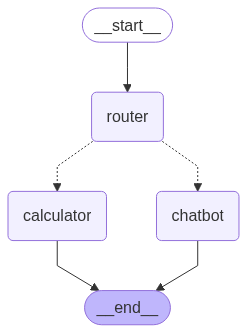

In [6]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass